# Struct2Vec Network Embedding and Clustering

In [3]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import datetime
import random
import re
import networkx as nx
import hdbscan
import matplotlib.pyplot as plt
import matplotlib as mpl
import umap

from node2vec import Node2Vec
from numpy.linalg import norm
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from umap.umap_ import UMAP

In [9]:
#Importing the Bitcoin OTC dataset
#Orginally assessible @ https://snap.stanford.edu/data/soc-sign-bitcoin-otc.html
file = r'C:\Users\Melis\OneDrive\Documents\Advanced Data Mining and Analytics\Project 3\soc-sign-bitcoinotc.csv.gz'

df = pd.read_csv(file, compression='gzip', header=None, names=['Source', 'Target', 'Rating', 'Time'])
print(df)

       Source  Target  Rating          Time
0           6       2       4  1.289242e+09
1           6       5       2  1.289242e+09
2           1      15       1  1.289243e+09
3           4       3       7  1.289245e+09
4          13      16       8  1.289254e+09
...       ...     ...     ...           ...
35587    4499    1810       1  1.453612e+09
35588    2731    3901       5  1.453679e+09
35589    2731    4897       5  1.453679e+09
35590      13    1128       1  1.453680e+09
35591    1128      13       2  1.453684e+09

[35592 rows x 4 columns]


In [11]:
#Checking the dataframe 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35592 entries, 0 to 35591
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Source  35592 non-null  int64  
 1   Target  35592 non-null  int64  
 2   Rating  35592 non-null  int64  
 3   Time    35592 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 1.1 MB


In [13]:
#Converting time from seconds since Epoch to datetime
df['Datetime'] = pd.to_datetime(df['Time'], unit='s')
print(df)

       Source  Target  Rating          Time                      Datetime
0           6       2       4  1.289242e+09 2010-11-08 18:45:11.728359936
1           6       5       2  1.289242e+09 2010-11-08 18:45:41.533780224
2           1      15       1  1.289243e+09 2010-11-08 19:05:40.390490112
3           4       3       7  1.289245e+09 2010-11-08 19:41:17.369750016
4          13      16       8  1.289254e+09 2010-11-08 22:10:54.447459840
...       ...     ...     ...           ...                           ...
35587    4499    1810       1  1.453612e+09 2016-01-24 05:14:41.647290112
35588    2731    3901       5  1.453679e+09 2016-01-24 23:50:28.049489920
35589    2731    4897       5  1.453679e+09 2016-01-24 23:50:34.034019840
35590      13    1128       1  1.453680e+09 2016-01-24 23:53:52.985709824
35591    1128      13       2  1.453684e+09 2016-01-25 01:12:03.757280000

[35592 rows x 5 columns]


### Struct2Vec - Network Embedding Application

In [15]:
#Creating directed graph of the data
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Rating'])

In [17]:
#Extracting sturctural signatures (k-hop Degree Sequences)
#for each node, computing the degree sequence of k-hop neighborhoods
def degree_signature(graph, node, k=3, max_len=10):
    signature = []
    for dist in range(1, k+1):
        neighbors = [n for n, d in nx.single_source_shortest_path_length(graph, node, cutoff=dist).items() if d == dist]
        degrees = sorted([graph.degree(n) for n in neighbors])
        # Pad or truncate to ensure fixed length
        padded = degrees[:max_len] + [0] * max(0, max_len - len(degrees))
        signature.extend(padded)
    return signature

nodes = list(G.nodes())
signature_matrix = np.array([degree_signature(G, node, k=3) for node in nodes])

In [19]:
#Computing similarity martix
def cosine_similarity_matrix(X):
    X_norm = X / (norm(X, axis=1, keepdims=True) + 1e-10)
    return np.dot(X_norm, X_norm.T)

similarity_matrix = cosine_similarity_matrix(signature_matrix)
distance_matrix = 1 - similarity_matrix

In [21]:
#Reducing to low dimensional embeddings
pca = PCA(n_components=8)  # Embedding dimension
embedding = pca.fit_transform(distance_matrix)

In [23]:
#Creating final embedding table
embedding_df = pd.DataFrame(embedding, index=nodes)
embedding_df.columns = [f'embed_{i}' for i in range(embedding.shape[1])]

# Combine with node ID if needed
embedding_df['node'] = embedding_df.index
embedding_df.reset_index(drop=True, inplace=True)

In [25]:
print(embedding_df)

        embed_0    embed_1    embed_2   embed_3   embed_4   embed_5   embed_6  \
0     12.163336   4.730608 -18.342917  1.128626  0.276001 -0.465466 -0.223412   
1     14.000478   6.606561 -17.380634  0.005585 -0.230445 -0.209341  0.228105   
2      3.193682 -18.427377  -3.146853 -4.753032  0.779693  5.010256 -1.289956   
3      7.036759  -1.037637 -16.036885  0.037855 -6.078234 -1.094369 -0.489755   
4     13.715483   7.237398 -14.689700  3.404587  1.111445  2.350577  2.575875   
...         ...        ...        ...       ...       ...       ...       ...   
5876 -24.846557   4.897955  -0.938919 -1.542570  3.373844  0.193129  0.022677   
5877   8.751647   3.841525  11.198687  1.098966  2.544046  0.644281  0.190609   
5878   8.751647   3.841525  11.198687  1.098966  2.544046  0.644281  0.190609   
5879   8.751647   3.841525  11.198687  1.098966  2.544046  0.644281  0.190609   
5880   8.751647   3.841525  11.198687  1.098966  2.544046  0.644281  0.190609   

       embed_7  node  
0   

In [27]:
embedding_df.to_csv('struc2vec-embeddings.csv')

### Struct2Vec - Clustering Embeddings

In [29]:
# Load embeddings
df_embed = pd.read_csv('struc2vec-embeddings.csv')
X = df_embed.drop('node', axis=1).values

In [43]:
# Defining Hopkins statistic function to check cluster tendency of Struct2Vec embeddings
# H ≈ 0.5 → Data is uniformly random (no meaningful clusters).
# H < 0.5 → Data likely has cluster structure.
# H > 0.5 → Rare in definition, but usually indicates anti-cluster structure or sampling issues.
def hopkins_statistic(X, n_samples=min(100, 50)):
    X = np.asarray(X)
    n, d = X.shape
    m = min(n_samples, n//2)
    
    # Sample real points
    idx = random.sample(range(n), m)
    X_sample = X[idx]
    
    # Generate uniform points
    U = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, d))
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    u_dist, _ = nbrs.kneighbors(U)
    w_nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    w_dist, _ = w_nbrs.kneighbors(X_sample)
    w_dist = w_dist[:, 1].reshape(-1, 1)
    H = np.sum(u_dist) / (np.sum(u_dist) + np.sum(w_dist))
    
    return H

In [45]:
# Standardizing embeddings so each feature contributes equally to distance calculations
# Where the mean=0, and the std.dev=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Running the Hopkins function on scaled data
H_scaled = hopkins_statistic(X_scaled)
print(f'Hopkins (scaled): {H_scaled:.3f}')

Hopkins (scaled): 0.957


In [47]:
# Dimensionality reduction with PCA (retain 90% variance)
pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f'PCA reduced dimensions: {X_pca.shape[1]}')

# Hopkins on PCA-reduced data
H_pca = hopkins_statistic(X_pca)
print(f'Hopkins (PCA): {H_pca:.3f}')

PCA reduced dimensions: 8
Hopkins (PCA): 0.941


In [49]:
# Try density-based clustering if clusterable
if H_pca < 0.5:
    db = DBSCAN(eps=0.5, min_samples=5).fit(X_pca)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f'DBSCAN found {n_clusters} clusters')
else:
    print("Data still not clusterable — consider tuning embedding hyperparameters or trying alternative distance metrics.")

Data still not clusterable — consider tuning embedding hyperparameters or trying alternative distance metrics.


In [51]:
#Checking signature matrix data integrity 
#Raising assertion error if something is wrong
assert not np.isnan(signature_matrix).any(), "NaNs in signature_matrix!"
assert not np.isinf(signature_matrix).any(), "Infs in signature_matrix!"
assert not np.isnan(distance_matrix).any(),  "NaNs in distance_matrix!"
assert not np.isinf(distance_matrix).any(),  "Infs in distance_matrix!"

In [61]:
embedding = X

# re-running PCA with slight variation to check Hopkins stat.
Xs = StandardScaler().fit_transform(embedding)
Xp = PCA(n_components=0.90, random_state=42).fit_transform(Xs)
print(f"Clustering on {Xp.shape[1]} dimensions covering ≥90% variance")

H = hopkins_statistic(Xp)
print(f"Hopkins on PCA-90% data: {H:.3f}")

Clustering on 8 dimensions covering ≥90% variance
Hopkins on PCA-90% data: 0.939


In [63]:
#Running HDBSCAN on PCA Reduced embeddings to see number of roles found 
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
labels = clusterer.fit_predict(Xp)
n_roles = len(set(labels) - {-1})
print(f"HDBSCAN found {n_roles} roles + noise")

C:\Users\Melis\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Melis\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN found 46 roles + noise


In [57]:
#Selecting clusters to use for GMM
bics = []
for k in range(2,11):
    gm = GaussianMixture(n_components=k, random_state=42).fit(Xp)
    bics.append((k, gm.bic(Xp)))
print("GMM BICs:", bics)

GMM BICs: [(2, 38728.86171433429), (3, -61526.12717841676), (4, -80315.16125994707), (5, -97954.76963398153), (6, -57791.15518146546), (7, -126653.03860189632), (8, -161255.907425046), (9, -163393.48197826667), (10, -164744.19417991032)]


In [59]:
#Evaluating clusters
mask = labels >= 0  # ignore noise if using DBSCAN/HDBSCAN
print("Silhouette:", silhouette_score(Xp[mask], labels[mask]))
print("DB index:", davies_bouldin_score(Xp[mask], labels[mask]))

Silhouette: 0.455961768515107
DB index: 0.5122681600285195


In [73]:
# UMAP → 2D Projection
umap2d = umap.UMAP(n_components=2, random_state=42).fit_transform(Xp)

# DBSCAN in 2D
labels2 = DBSCAN(eps=0.5, min_samples=5).fit_predict(umap2d)

# Prepare DataFrame
df_umap = pd.DataFrame(umap2d, columns=['x', 'y'])
df_umap['cluster'] = labels2

# Hardcoded List of Starkly Distinct Colors
distinct_colors = [
    '#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd',
    '#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf',
    '#393b79','#637939','#8c6d31','#843c39','#7b4173',
    '#5254a3','#6b6ecf','#9c9ede','#cedb9c','#e7cb94',
    '#f7f7f7','#c7c7c7','#ff9896','#c5b0d5','#8c8c8c',
    '#ffbb78','#98df8a','#aec7e8','#ffbb44','#c49c94'
]

# Ensure we have at least as many colors as clusters
unique_labels = sorted(np.unique(labels2))
assert len(distinct_colors) >= len(unique_labels), "Not enough distinct colors defined!"

# Map each cluster to a stark color
color_map = {cl: distinct_colors[i] for i, cl in enumerate(unique_labels)}

C:\Users\Melis\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


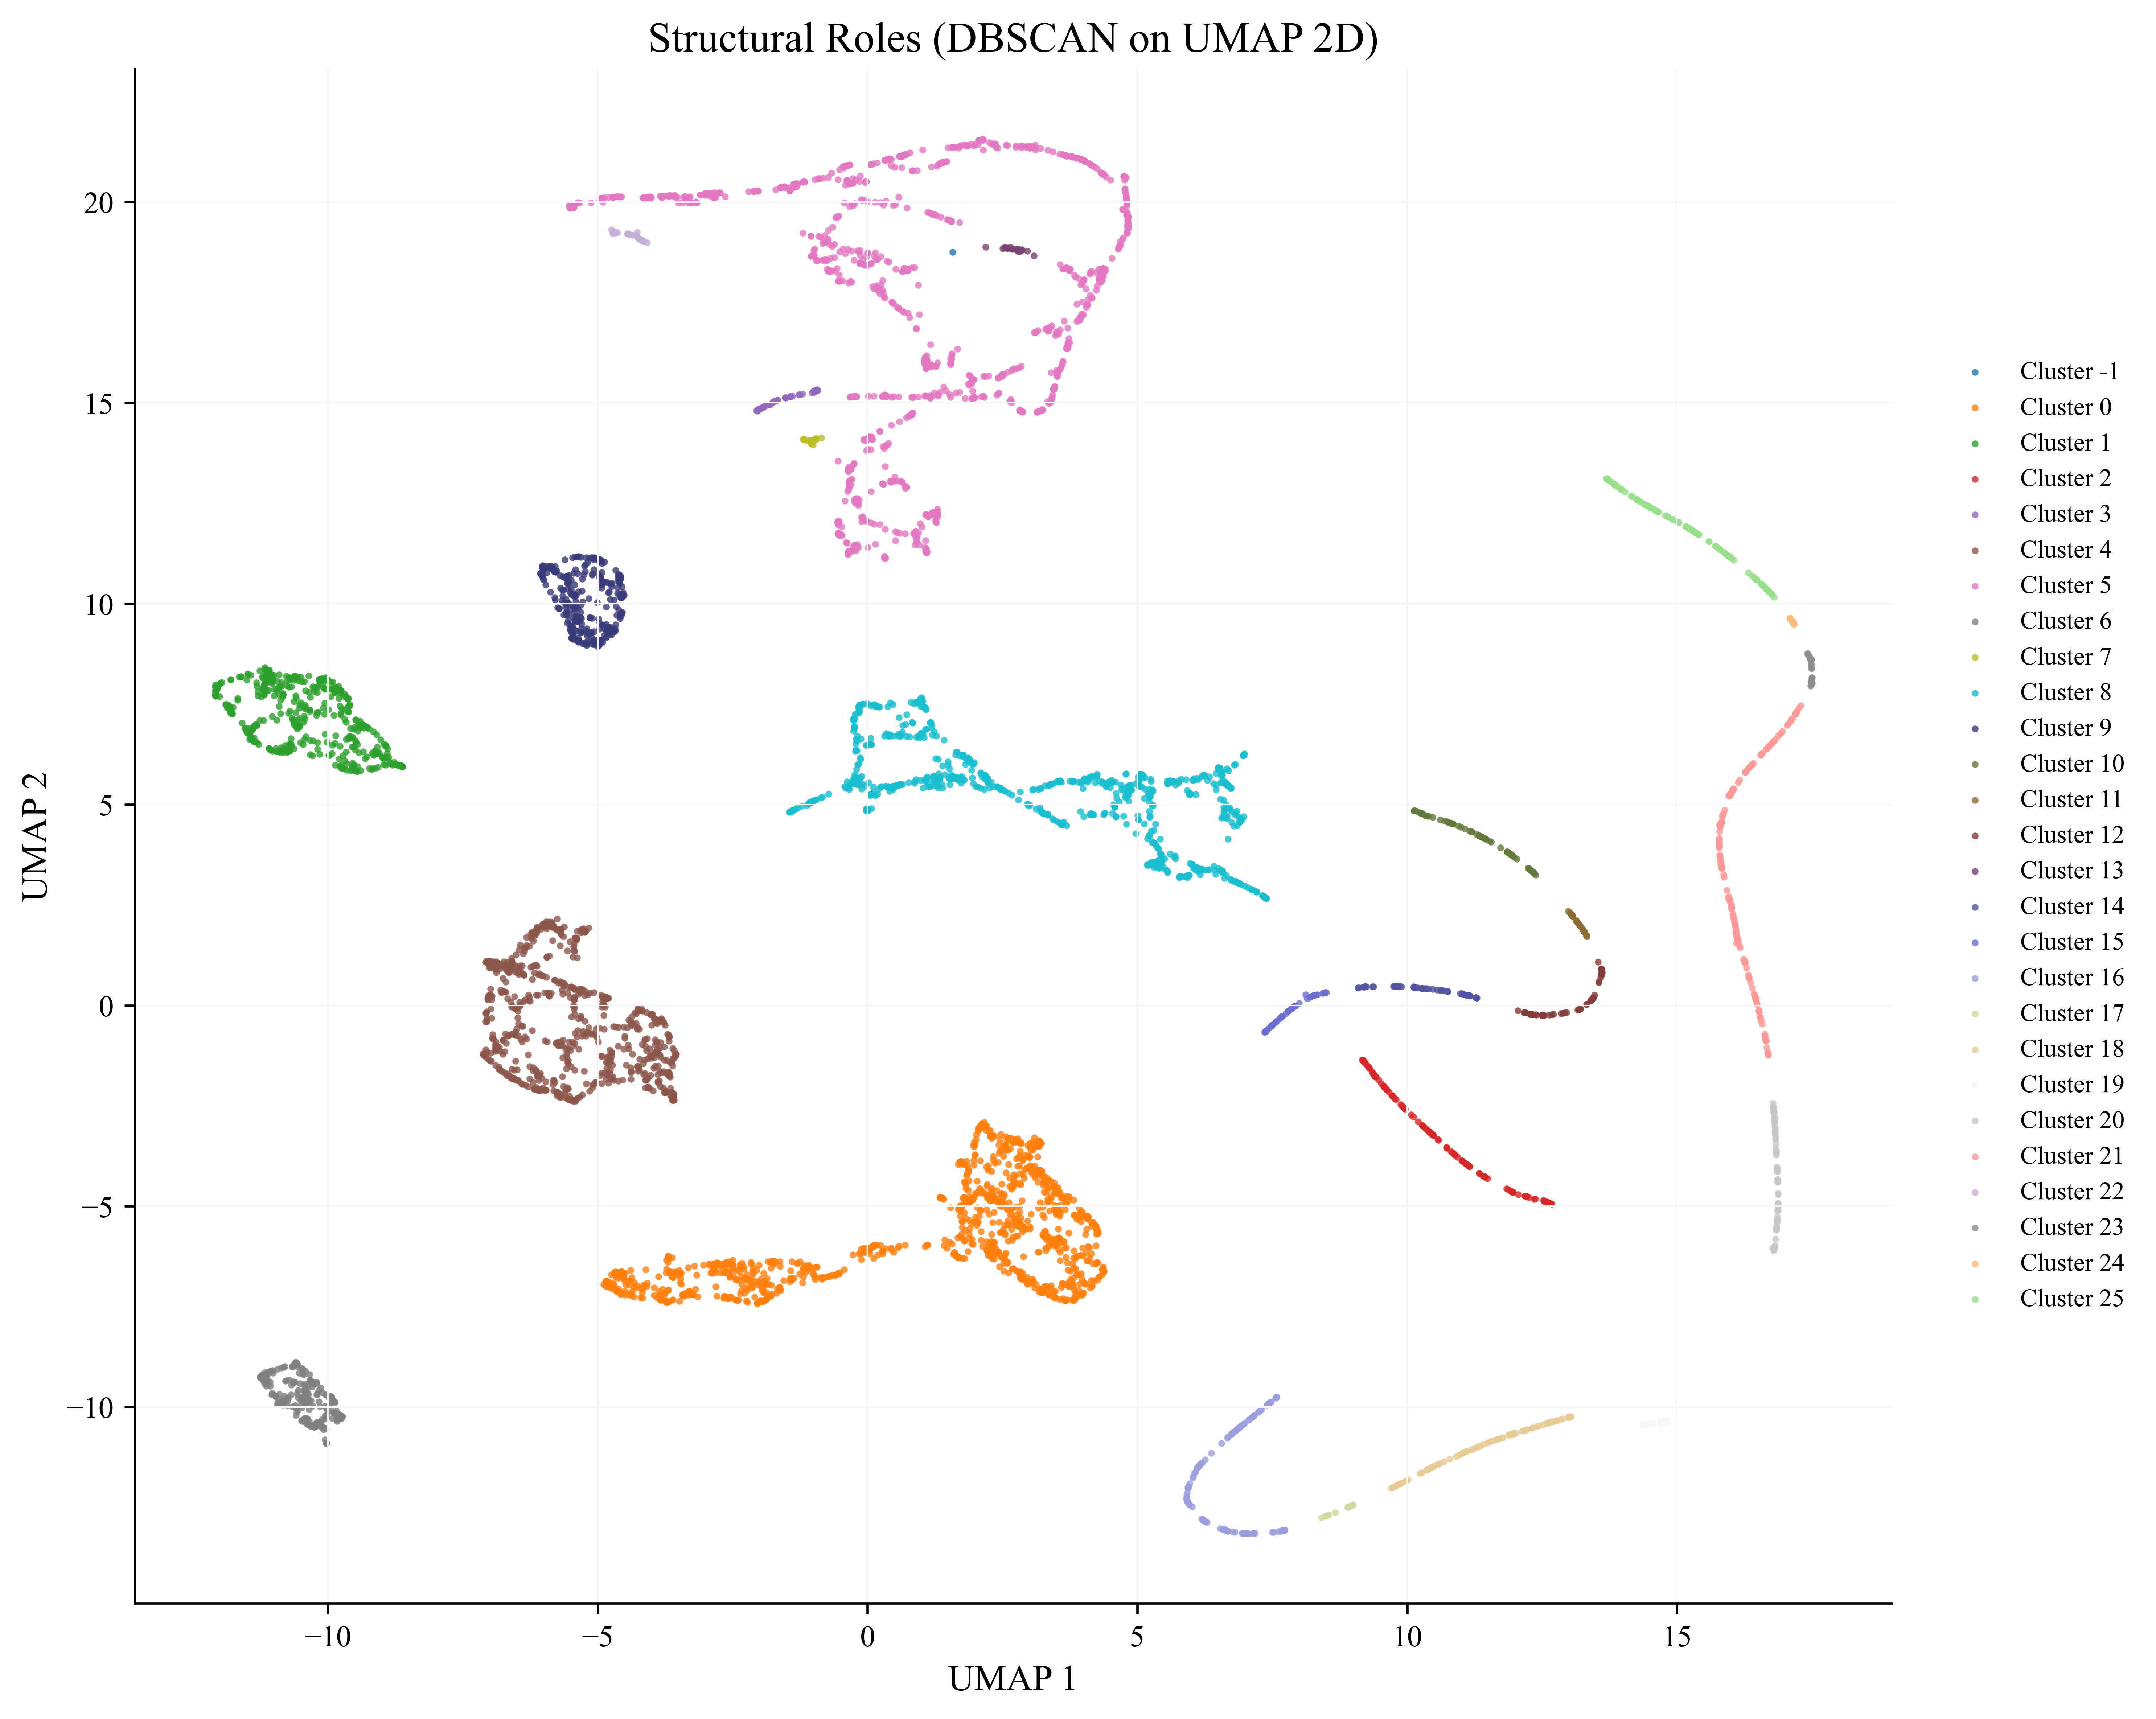

In [85]:
# Set global font to Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'

# Plot Each Cluster
fig, ax = plt.subplots(figsize=(10, 8), dpi=600)
for cl in unique_labels:
    pts = df_umap[df_umap['cluster'] == cl]
    ax.scatter(
        pts['x'], pts['y'],
        color=color_map[cl],
        s=5, alpha=0.8, linewidths=0,
        label=f"Cluster {cl}"
    )

# Legend and Styling
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, labels,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize='small'  # smaller legend font size
)

# Add grid with whitesmoke color and linewidth 0.5
ax.grid(color='whitesmoke', linewidth=0.5)

ax.set_title("Structural Roles (DBSCAN on UMAP 2D)", fontsize=14)
ax.set_xlabel("UMAP 1", fontsize=12)
ax.set_ylabel("UMAP 2", fontsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

In [91]:
# UMAP → 2D on 10-dim PCA embedding
umap2d = UMAP(n_components=2, random_state=42).fit_transform(Xp)

# DBSCAN clustering in the 2D space
labels2 = DBSCAN(eps=0.5, min_samples=5).fit_predict(umap2d)

# Map each node → its 2D cluster
df2d = pd.DataFrame({
    'node'     : nodes,     # same list used for signature_matrix
    'cluster2d': labels2
})

# Load edge list & compute per-node rating stats
edges = pd.read_csv(file, compression='gzip', header=None, names=['source', 'target', 'rating', 'time'])
src = edges.groupby('source').rating.agg(
    out_count='size',
    avg_out   ='mean'
)
tgt = edges.groupby('target').rating.agg(
    in_count ='size',
    avg_in   ='mean'
)

# Merge everything together
node2d = (
    df2d.set_index('node')
        .join(src, how='left')
        .join(tgt, how='left')
        .fillna(0)
        .reset_index()
)

# Summarize by cluster
summary2d = (
    node2d
    .groupby('cluster2d')
    .agg(
        size      = ('node',    'count'),
        avg_out   = ('avg_out', 'mean'),
        avg_in    = ('avg_in',  'mean'),
        total_out = ('out_count','sum'),
        total_in  = ('in_count','sum')
    )
    .sort_values('size', ascending=False)
)

print(summary2d)

C:\Users\Melis\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


           size   avg_out    avg_in  total_out  total_in
cluster2d                                               
 0         1164  1.156402  0.992494    27842.0   25259.0
 5         1045  2.077512  1.091434     1045.0    1315.0
 8          797  1.914696  1.054434     1513.0    1590.0
 4          703  1.723329  0.980907     1406.0    1587.0
 1          450  1.389630  1.087929     1350.0    1400.0
 9          291  1.315292  0.757291     1164.0    1281.0
 6          227  1.449339  1.099774     1135.0    1160.0
 21         172  0.029070 -2.203488        1.0     231.0
 16         133  0.000000  0.482444        0.0     200.0
 2          131  0.000000  1.480744        0.0     335.0
 25         105  0.000000 -0.086054        0.0     128.0
 18          94  0.106383 -0.188360        1.0     144.0
 20          77  0.000000 -5.018398        0.0      98.0
 10          74  0.000000  0.827358        0.0     183.0
 12          65  0.000000 -2.006410        0.0     116.0
 14          54  0.000000 -0.34

### Results

In [104]:
# Map cluster IDs (index) to color hex and color name
color_info = {
    0: ('#1f77b4', 'Blue'),
    1: ('#ff7f0e', 'Orange'),
    2: ('#2ca02c', 'Green'),
    3: ('#d62728', 'Red'),
    4: ('#9467bd', 'Purple'),
    5: ('#8c564b', 'Brown'),
    6: ('#e377c2', 'Pink'),
    7: ('#7f7f7f', 'Gray'),
    8: ('#bcbd22', 'Olive'),
    9: ('#17becf', 'Cyan'),
    10: ('#393b79', 'Navy'),
    11: ('#637939', 'Dark Green'),
    12: ('#8c6d31', 'Dark Brown'),
    13: ('#843c39', 'Dark Red'),
    14: ('#7b4173', 'Dark Purple'),
    15: ('#5254a3', 'Slate Blue'),
    16: ('#6b6ecf', 'Medium Blue'),
    17: ('#9c9ede', 'Light Blue'),
    18: ('#cedb9c', 'Light Olive'),
    19: ('#e7cb94', 'Tan'),
    20: ('#f7f7f7', 'White Smoke'),
    21: ('#c7c7c7', 'Light Gray'),
    22: ('#ff9896', 'Salmon'),
    23: ('#c5b0d5', 'Lavender'),
    24: ('#8c8c8c', 'Dim Gray'),
    25: ('#ffbb78', 'Pastel Orange'),
    -1: ('#000000', 'Black (Noise)')
}

# Interpretations dictionary
interpretations = {
    0:  "Everyday participants with modest positive trust.",
    1:  "Well-liked regulars with balanced trust.",
    2:  "Collectors trusted by others but no outgoing trust.",
    3:  "Core influencers highly engaged with high outgoing and incoming trust.",
    4:  "Connectors linking parts of the network.",
    5:  "Optimistic givers with high outgoing trust.",
    6:  "Balanced participants evenly matched.",
    7:  "Generous participants consistently active with high outgoing and incoming trust.",
    8:  "Frequent raters with balanced trust.",
    9:  "Cautious givers with moderate outgoing trust.",
    10: "Passive receivers who don’t rate others but receive modest positive trust.",
    11: "Neutral participants with almost no outgoing or incoming trust activity.",
    12: "Negative sinks with no outgoing and noticeably negative incoming trust.",
    13: "Occasional givers with moderate outgoing and low incoming trust.",
    14: "Low engagement negatives with no outgoing and mildly negative feedback.",
    15: "Small negative participants with low outgoing and negative incoming trust.",
    16: "Silent receivers with modest incoming trust.",
    17: "Distrusted nodes with no outgoing and strongly negative incoming feedback.",
    18: "Mildly distrusted with minimal outgoing and slightly negative incoming trust.",
    19: "Quiet trust holders with no outgoing and moderate positive incoming trust.",
    20: "Strongly distrusted with no outgoing and sharply negative incoming trust.",
    21: "Distrusted sinks with negative incoming trust.",
    22: "Active givers with high outgoing and positive incoming trust, likely opinion leaders.",
    23: "Occasional receivers with no outgoing activity but some incoming trust.",
    24: "Negative small group with no outgoing and moderately negative incoming trust.",
    25: "Inactive neutrals with no outgoing and near-zero incoming trust.",
    -1: "Noise/outliers, unclustered nodes with average trust values."
}

# Add columns by mapping index values
summary2d['Color Hex'] = summary2d.index.map(lambda x: color_info.get(x, ('#000000', 'Unknown'))[0])
summary2d['Color Name'] = summary2d.index.map(lambda x: color_info.get(x, ('#000000', 'Unknown'))[1])
summary2d['Interpretation'] = summary2d.index.map(lambda x: interpretations.get(x, "No interpretation available."))

# Reset index to turn cluster IDs into a column
summary2d_out = summary2d.reset_index()

# Rename and reorder columns for display
summary2d_out = summary2d_out.rename(columns={
    'cluster2d': 'Cluster',
    'size': 'Size',
    'avg_out': 'avg_out',
    'avg_in': 'avg_in',
    'Color Name': 'Color (in legend)',
    'Interpretation': 'Interpretation'
})

summary2d_out = summary2d_out[['Cluster', 'Color (in legend)', 'Size', 'avg_out', 'avg_in', 'Interpretation']]

|   Cluster | Color (in legend)   |   Size |   avg_out |       avg_in | Interpretation                                                                        |
|----------:|:--------------------|-------:|----------:|-------------:|:--------------------------------------------------------------------------------------|
|         0 | Blue                |   1164 | 1.1564    |  0.992494    | Everyday participants with modest positive trust.                                     |
|         5 | Brown               |   1045 | 2.07751   |  1.09143     | Optimistic givers with high outgoing trust.                                           |
|         8 | Olive               |    797 | 1.9147    |  1.05443     | Frequent raters with balanced trust.                                                  |
|         4 | Purple              |    703 | 1.72333   |  0.980907    | Connectors linking parts of the network.                                              |
|         1 | Orange              |    450 | 1.38963   |  1.08793     | Well-liked regulars with balanced trust.                                              |
|         9 | Cyan                |    291 | 1.31529   |  0.757291    | Cautious givers with moderate outgoing trust.                                         |
|         6 | Pink                |    227 | 1.44934   |  1.09977     | Balanced participants evenly matched.                                                 |
|        21 | Light Gray          |    172 | 0.0290698 | -2.20349     | Distrusted sinks with negative incoming trust.                                        |
|        16 | Medium Blue         |    133 | 0         |  0.482444    | Silent receivers with modest incoming trust.                                          |
|         2 | Green               |    131 | 0         |  1.48074     | Collectors trusted by others but no outgoing trust.                                   |
|        25 | Pastel Orange       |    105 | 0         | -0.0860544   | Inactive neutrals with no outgoing and near-zero incoming trust.                      |
|        18 | Light Olive         |     94 | 0.106383  | -0.18836     | Mildly distrusted with minimal outgoing and slightly negative incoming trust.         |
|        20 | White Smoke         |     77 | 0         | -5.0184      | Strongly distrusted with no outgoing and sharply negative incoming trust.             |
|        10 | Navy                |     74 | 0         |  0.827358    | Passive receivers who don’t rate others but receive modest positive trust.            |
|        12 | Dark Brown          |     65 | 0         | -2.00641     | Negative sinks with no outgoing and noticeably negative incoming trust.               |
|        14 | Dark Purple         |     54 | 0         | -0.348765    | Low engagement negatives with no outgoing and mildly negative feedback.               |
|        15 | Slate Blue          |     51 | 0.196078  | -0.741667    | Small negative participants with low outgoing and negative incoming trust.            |
|         3 | Red                 |     51 | 2.05882   |  1.68301     | Core influencers highly engaged with high outgoing and incoming trust.                |
|        22 | Salmon              |     38 | 2.44737   |  0.853509    | Active givers with high outgoing and positive incoming trust, likely opinion leaders. |
|        23 | Lavender            |     28 | 0         |  0.142857    | Occasional receivers with no outgoing activity but some incoming trust.               |
|        19 | Tan                 |     27 | 0         |  1.02469     | Quiet trust holders with no outgoing and moderate positive incoming trust.            |
|        11 | Dark Green          |     26 | 0         |  0.000518926 | Neutral participants with almost no outgoing or incoming trust activity.              |
|        13 | Dark Red            |     23 | 2.30435   |  0.126812    | Occasional givers with moderate outgoing and low incoming trust.                      |
|         7 | Gray                |     21 | 2.19048   |  1.69048     | Generous participants consistently active with high outgoing and incoming trust.      |
|        17 | Light Blue          |     19 | 0         | -1.64912     | Distrusted nodes with no outgoing and strongly negative incoming feedback.            |
|        24 | Dim Gray            |     14 | 0         | -1.09524     | Negative small group with no outgoing and moderately negative incoming trust.         |
|        -1 | Black (Noise)       |      1 | 1         |  1           | Noise/outliers, unclustered nodes with average trust values.                          |
